In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import time
import importlib

# import pdb

# Hyper Parameters
EPOCH = 100
BATCH_SIZE = 512
LR = 0.001         # learning rate
MNT = 0.9
WD = .0         # weight decay
DOWNLOAD_MNIST = False
N_TEST_IMG = 5
K = 50
m = 500
cudaopt = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='../data',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)



In [2]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

import models as mds
importlib.reload(mds)

autoencoder = mds.AutoEncoder(m).to(device)
# 
    
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR,weight_decay=WD)
loss_func = nn.MSELoss()


Before Training


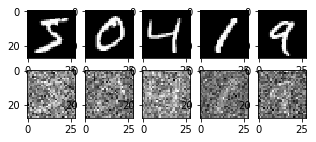

In [3]:
# initialize figure
print('Before Training')

fig = plt.figure(figsize=(5, 2))

# original data (first row) for viewing
view_data = Variable(train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.)
view_data = view_data.to(device)
    
encoded_data,decoded_data, nnz, res = autoencoder(view_data,K)

for i in range(N_TEST_IMG):
    plt.subplot(2,N_TEST_IMG,i+1)
    plt.imshow(np.reshape(view_data.cpu().data.numpy()[i], (28, 28)), cmap='gray')

for i in range(N_TEST_IMG):
    plt.subplot(2,N_TEST_IMG,i+6)
    plt.imshow(np.reshape(decoded_data.cpu().data.numpy()[i], (28, 28)), cmap='gray')
    
plt.show()

In [ ]:
# Training
Loss = np.empty(1)
Ts = []
N = train_data.train_data.shape[0]
DISPLAY_FREQ = 1 ; 
TSHOW = np.round(DISPLAY_FREQ * N/BATCH_SIZE) # times per EPOCH to display information
t0 = time.perf_counter()
Ts = np.append(Ts,t0)
Kmax = 100
Ktarget = 25
K = Kmax
DimK = 1


for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = (x.view(-1, 28*28)).to(device)   # batch x, shape (batch, 28*28)
        b_y = (x.view(-1, 28*28)).to(device)   # batch y, shape (batch, 28*28)
        b_label = (y).to(device)               # batch label

        encoded, decoded, nnz,_ = autoencoder(b_x,int(K))

        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
        
        Loss = np.append(Loss,loss.data[0])
        if (step+1) % TSHOW == 0:
            Ts = np.append(Ts,time.perf_counter())
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data[0], '| speed: %.2e' %  (TSHOW*BATCH_SIZE/(Ts[-1] - Ts[-2])) ,' Hz | NNZ: ',nnz )
                
    K = max( Kmax - np.floor( (epoch+1)/DimK) ,Ktarget)
#     print('Finished Epoch: ', epoch, '| time ', np.round( 100*(Ts[-1] - Ts[-2]))/100 )


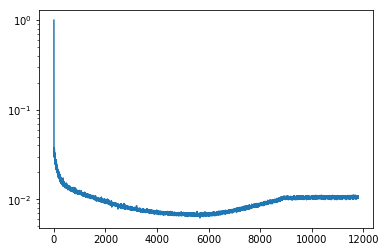

After Training


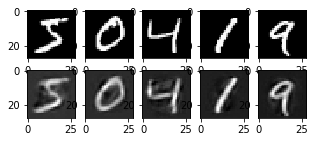

In [10]:
fig = plt.figure(facecolor='white')
plt.semilogy(Loss)
plt.show()

print('After Training')
fig = plt.figure(figsize=(5, 2))
# original data (first row) for viewing
view_data = Variable(train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.)
view_data = view_data.to(device)
encoded_data,decoded_data,_,_ = autoencoder(view_data,int(K))

for i in range(N_TEST_IMG):
    plt.subplot(2,N_TEST_IMG,i+1)
    plt.imshow(np.reshape(view_data.cpu().data.numpy()[i], (28, 28)), cmap='gray')

for i in range(N_TEST_IMG):
    plt.subplot(2,N_TEST_IMG,i+6)
    plt.imshow(np.reshape(decoded_data.cpu().data.numpy()[i], (28, 28)), cmap='gray')
    
plt.show()

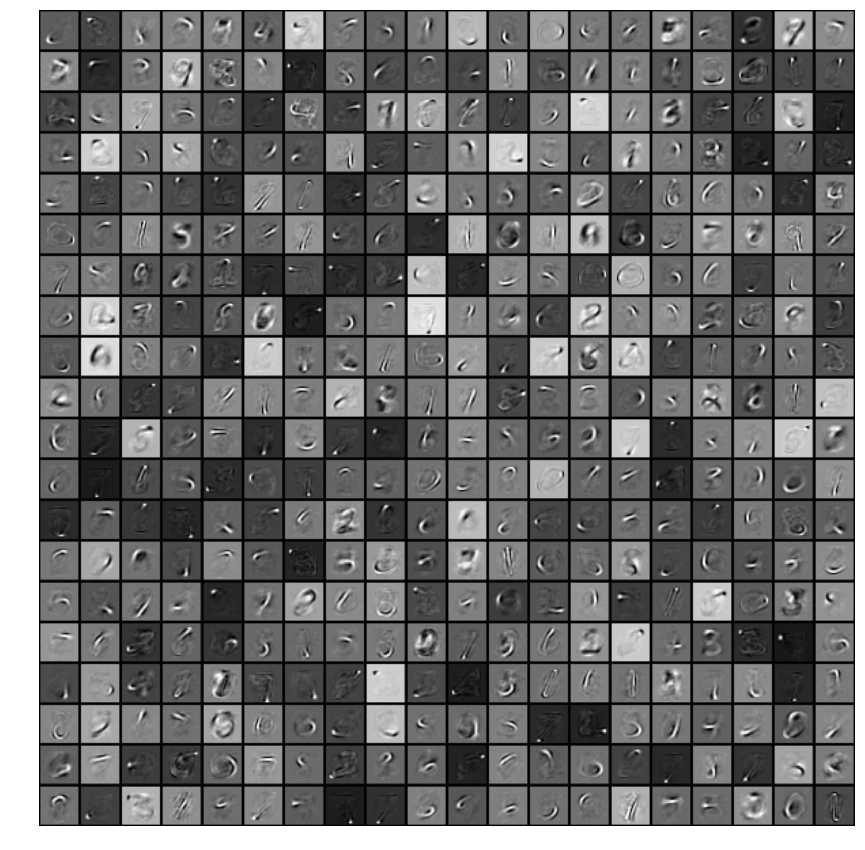

In [11]:
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

def showFilters(W,ncol,nrows):
    p = int(np.sqrt(W.shape[0]))+2
    Nimages = W.shape[1]
    Mosaic = np.zeros((p*ncol,p*nrows))
    indx = 0
    for i in range(ncol):
        for j in range(nrows):
            im = W[:,indx].reshape(p-2,p-2)
            im = (im-np.min(im))
            im = im/np.max(im)
            Mosaic[ i*p : (i+1)*p , j*p : (j+1)*p ] = np.pad(im,(1,1),mode='constant')
            indx += 1
            
    return Mosaic

W = autoencoder.cpu().W.data.numpy()
b1 = autoencoder.cpu().b1.data.numpy()
b2 = autoencoder.cpu().b2.data.numpy()

M1 = showFilters(W,20,20)
plt.figure(figsize=(15,15))
plt.imshow(rescale(M1,4,mode='constant'),cmap='gray')
plt.axis('off')
plt.show()